In [24]:
## Подключаем необходимые библиотеки
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')
import pandas as pd
import seaborn
import matplotlib
import yfinance as yf
from pandas_datareader import data as pdr
from yahoo_fin.stock_info import get_data
import yahoo_fin.stock_info as si
from pandas_datareader import data as web
import datetime
from nsepy import get_history
from get_all_tickers import get_tickers as gt
from get_all_tickers.get_tickers import Region
from nsepython import *
import logging
urllib3_logger = logging.getLogger('urllib3') # Обработчик сообщений, чтобы они не выводились при сборе данных о тикерах
urllib3_logger.setLevel(logging.CRITICAL)

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [25]:
list_of_tickers = ["VNQ", "SCHH", "IYR", "XLRE", "ICF", "USRT", "RWR", "REM", "FREL", "BBRE", "SRVR", "REZ", "SRET", "VNQI"]
# Задаем диапазон дат в котором нужно собирать все данные по тикерам
start = datetime.datetime(2010,1,1)
end = datetime.datetime(2020,12,31) # сегодняшняя дата, чтобы не менять вручную.
# Получаем данные из Yahoo. Именно этот способ позволяет получить данные с тикерами в столбцах.
f = pdr.DataReader(list_of_tickers, 'yahoo', start, end)





# # Read the csv file using read_csv method of pandas
# prices = pd.read_csv('/Users/liliaromanova/Downloads/Momentum-Trading-Strateges-Resources/data/security_prices_2000_2019.csv', index_col=0)

# # Set the index to datetime
# prices.index = pd.to_datetime(prices.index)

# prices.tail()



In [26]:
f = pd.DataFrame(f["Close"])

prices = f
# Set the index to datetime
prices.index = pd.to_datetime(prices.index)
prices.tail()

Symbols,VNQ,SCHH,IYR,XLRE,ICF,USRT,RWR,REM,FREL,BBRE,SRVR,REZ,SRET,VNQI
Date,,,,,,,,,,,,,,
2020-12-24,83.879997,37.459999,84.290001,35.910000,52.869999,47.770000,85.360001,31.650000,25.059999,78.110001,35.169998,66.930000,8.900,53.619999
2020-12-28,84.379997,37.790001,85.059998,36.200001,53.369999,48.169998,86.139999,31.870001,25.240000,78.750000,35.310001,67.300003,8.975,53.810001
2020-12-29,83.660004,37.490002,84.370003,35.919998,52.889999,47.720001,85.309998,31.469999,25.000000,78.059998,35.290001,66.879997,8.920,54.200001
2020-12-30,84.120003,37.549999,84.750000,36.119999,53.200001,47.930000,85.860001,31.670000,25.120001,78.419998,35.369999,67.239998,8.880,54.450001
2020-12-31,84.930000,37.970001,85.650002,36.560001,53.880001,48.410000,86.699997,31.860001,25.379999,79.150002,35.849998,67.849998,8.890,54.310001


In [27]:
# Import pearsonr from scipy.stats
from scipy.stats import pearsonr

def calc_corr(df, lookback, hold):
    
    # Create a copy of the dataframe
    data = df.copy()
    
    # Calculate lookback returns
    data['lookback_returns'] = data['price'].pct_change(lookback)
    
    # Calculate hold returns
    data['future_hold_period_returns'] = data['price'].pct_change(hold).shift(-hold)
    
    data = data.dropna()
    data = data.iloc[::hold]
    
    # Calculate correlation coefficient and p-value
    corr, p_value = pearsonr(data.lookback_returns,
                             data.future_hold_period_returns)
    return corr, p_value

In [28]:
def plot_grid(data_to_plot, vmin, vmax, cmap, title_name):

    # Plot heatmap and set the style
    fig, ax = plt.subplots(figsize=(10, 7))
    ax = seaborn.heatmap(data_to_plot, cmap=cmap,
                         annot=True, vmin=vmin, vmax=vmax, xticklabels=hold, yticklabels=lookback)
    
    # Adjust top and bottom y-axis
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

    # Label the heatmap
    plt.title(title_name, fontsize=14)
    plt.xlabel('Hold', fontsize=12)
    plt.ylabel('Lookback', fontsize=12)
    plt.show()

In [61]:
# Define lookback periods
lookback = [15, 30, 60, 90, 150, 240, 360]

# Define holding periods
hold = [5, 10, 15, 30, 45, 60]

# Create a dataframe which stores price of a security
crude_data = pd.DataFrame()
crude_data['price'] = prices["VNQI"]
crude_data.dropna()

# Create an array of length lookback*hold
corr_grid = np.zeros((len(lookback), len(hold)))
p_value_grid = np.zeros((len(lookback), len(hold)))

# Run through a length of lookback and holding periods
for i in range(len(lookback)):
    for j in range(len(hold)):

        # Call calc_corr function and calculate correlation coefficient and p-value
        corr_grid[i][j], p_value_grid[i][j] = calc_corr(
            crude_data, lookback[i], hold[j])


DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f96ea8c75b0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f96ea8c75b0> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh


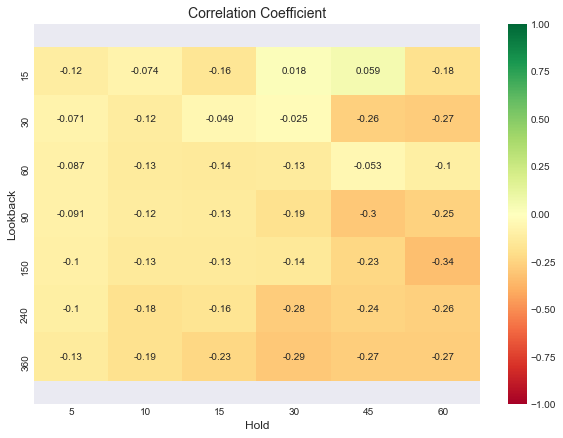

Lookback Optimal: 15
Hold Optimal: 45


In [62]:
# Call plot_grid function and plot correlation cofficient
plot_grid(corr_grid, vmin=-1, vmax=1, cmap='RdYlGn',
          title_name='Correlation Coefficient')

# Find maximum value of correlation coefficient
opt = np.where(corr_grid == np.max(corr_grid))

# Find the optimal lookback and holding period
opt_lookback = lookback[opt[0][0]]
opt_hold = hold[opt[1][0]]
print('Lookback Optimal:', opt_lookback)
print('Hold Optimal:', opt_hold)

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f96e58bca60>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f96e58bca60> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh


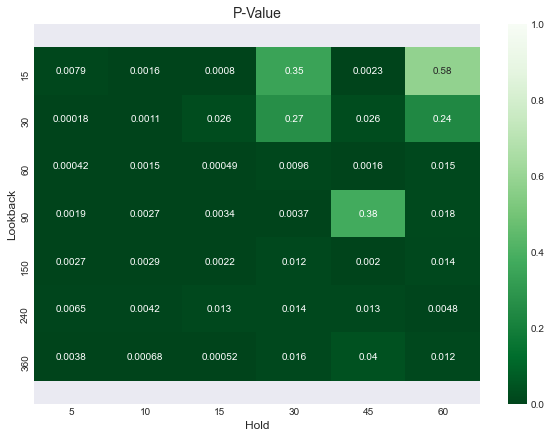

In [31]:
# Call plot_grid function and plot p-value
plot_grid(p_value_grid, vmin=0, vmax=1, cmap='Greens_r', title_name='P-Value')

In [32]:
def calc_returns(data, lookback, hold, title_name):

    # Calculate returns over a lookback period
    data['lookback_returns'] = data['price'].pct_change(lookback)

    # Calculate future returns
    data['future_hold_period_returns'] = data['price'].pct_change(hold).shift(-hold)

    # Define strategy logic
    data['positions'] = np.where(data['lookback_returns'] > 0, 1, -1)

    data = data.dropna()
    data = data.iloc[::hold]

    # Calculate strategy returns
    data['strategy_returns'] = data['future_hold_period_returns'] * data['positions']
    cum_rets = (data['strategy_returns']+1).cumprod()
    
# ------------------------------------------------------------------------------------    

    # Calculate Sharpe ratio
    sharpe = (np.mean(data['strategy_returns']) /
              np.std(data['strategy_returns'])*((252/hold)**0.5))
    print(title_name + ' Sharpe Ratio:', sharpe)

# ------------------------------------------------------------------------------------    

    # Plot and lable the graphs
    fig = plt.figure(figsize=(16, 7))    
    sub = fig.add_subplot(1, 2, 1)
    cum_rets.plot()
    sub.set_ylabel('Cumulative Returns', fontsize=12)
    sub.set_xlabel('Date', fontsize=12)
    
# ------------------------------------------------------------------------------------        

    # Calculate the running maximum
    running_max = np.maximum.accumulate(cum_rets.dropna())
    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1
    # Calculate the percentage drawdown
    drawdown = ((cum_rets)/running_max - 1)

    # Plot drawdown
    sub = fig.add_subplot(1, 2, 2)    
    drawdown.plot(color='r') 
    sub.set_ylabel('Returns',fontsize=12)
    sub.set_xlabel('Date',fontsize=12)
    plt.show()

In [33]:

# Create a dataframe which stores the correlation coefficient and p-value
corr_pvalue = pd.DataFrame()

# Create a dataframe which stores price data of all securities
data = pd.DataFrame()

# Securities with Hurst exponent greater than 0.65
price = prices[["VNQ", "SCHH", "IYR", "XLRE", "ICF", "USRT", "RWR", "REM", "FREL", "BBRE", "SRVR", "REZ", "SRET", "VNQI"]]

for column in price.columns:
    data['price'] = price[column]

    # Run through a length of lookback and holding period
    for i in range(len(lookback)):
        for j in range(len(hold)):

            # Calculate correlation coefficient and p-value
            corr, p_value = calc_corr(data, lookback[i], hold[j])

            # Append correlation and p-value in a dataframe
            corr_pvalue = corr_pvalue.append(
                [[column, lookback[i], hold[j], corr, p_value]])

corr_pvalue.columns = ['Instrument', 'Lookback',
                       'Hold', 'Correlation', 'P_value']

# Set index of corr_pvalue dataframe
corr_pvalue.reset_index(inplace=True, drop=True)
corr_pvalue

,Instrument,Lookback,Hold,Correlation,P_value
0,VNQ,15,5,-0.113096,0.007935
1,VNQ,15,10,-0.189243,0.001619
2,VNQ,15,15,-0.245805,0.000796
3,VNQ,15,30,-0.099586,0.347630
4,VNQ,15,45,-0.383803,0.002262
...,...,...,...,...,...
583,VNQI,360,10,-0.186370,0.005666
584,VNQI,360,15,-0.229822,0.005262
585,VNQI,360,30,-0.292396,0.012065
586,VNQI,360,45,-0.268647,0.064851


In [34]:
corr_pvalue_filtered = corr_pvalue.loc[(
    corr_pvalue['Correlation'] > 0) & (corr_pvalue['P_value'] < 0.1)]

corr_pvalue_filtered.head()

,Instrument,Lookback,Hold,Correlation,P_value
295,REM,15,10,0.118712,0.049229
297,REM,15,30,0.414030,0.000045
299,REM,15,60,0.282122,0.060434


In [35]:
# Keep lookback and holding period with highest correlation
max_correlation = corr_pvalue_filtered.groupby(
    ['Instrument'])['Correlation'].transform(max) == corr_pvalue_filtered['Correlation']


corr_pvalue_filtered[max_correlation]

,Instrument,Lookback,Hold,Correlation,P_value
297,REM,15,30,0.41403,0.000045


REM Sharpe Ratio: 0.48140714589001327


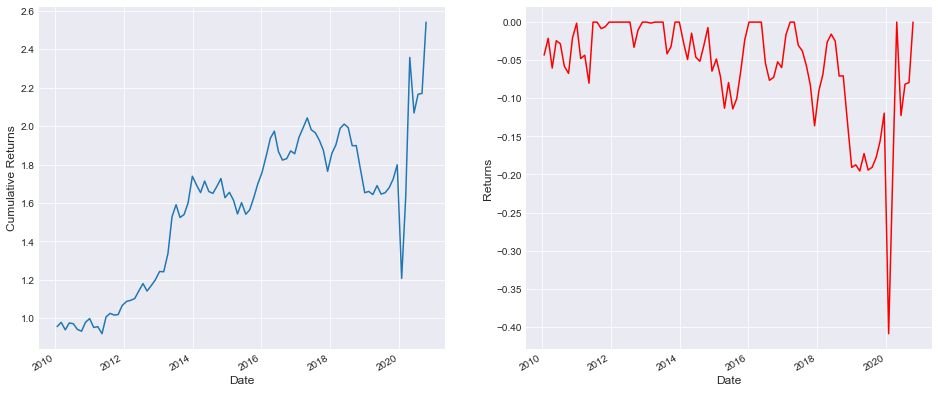

In [36]:
for i in corr_pvalue_filtered[max_correlation].index:

    instrument = corr_pvalue_filtered[max_correlation].loc[i, 'Instrument']
    lookback = corr_pvalue_filtered[max_correlation].loc[i, 'Lookback']
    hold = corr_pvalue_filtered[max_correlation].loc[i, 'Hold']
    data['price'] = price[instrument]
    
    calc_returns(data, lookback, hold, instrument)